# Reconstruction of volume from simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2

plt.rcParams["figure.figsize"]=8,8

### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

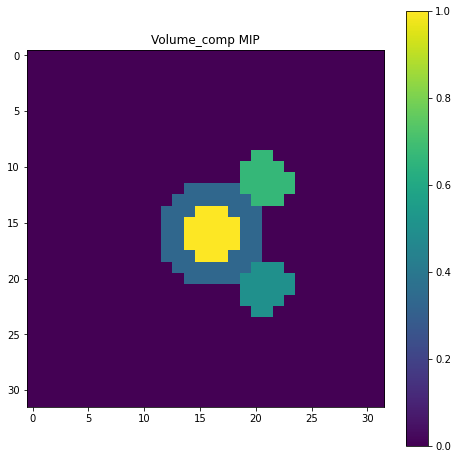

In [7]:
nx = 32
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])
pixel_size = dimensions[0]/shape[0]

# A volume with components
centres = np.array([[0,0,0], [3, 3, 0], [3, -3, 0], [0,0,3]])
radii = np.array([3, 1.5, 1.5, 1.5])
intensities = np.array([10,15,20, 20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid, _ = volume_fourier(vol, pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

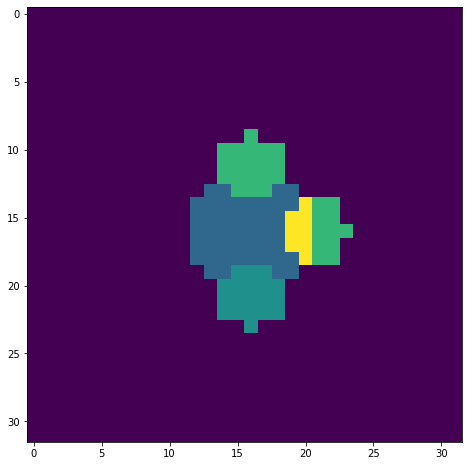

In [8]:
mip_y(vol)

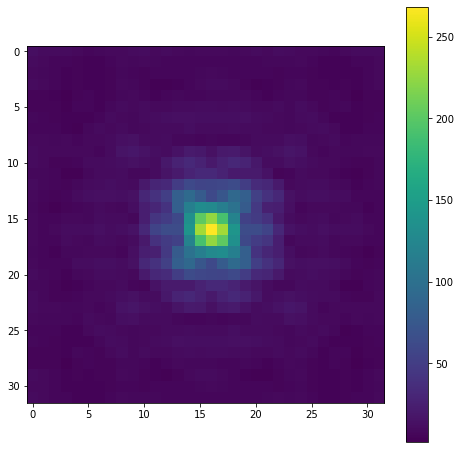

In [9]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

### Generate the data

CTF

In [10]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
_, p = next(dfiter)

#ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE], 
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC], 
#              'cs'    : p[star.Relion.CS], 
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array([p[star.Relion.DEFOCUSU],
                      p[star.Relion.DEFOCUSV],
                      p[star.Relion.DEFOCUSANGLE], 
                      p[star.Relion.PHASESHIFT],
                      p[star.Relion.VOLTAGE],
                      p[star.Relion.AC],
                      p[star.Relion.CS],
                      0,
                      2 * pixel_size])

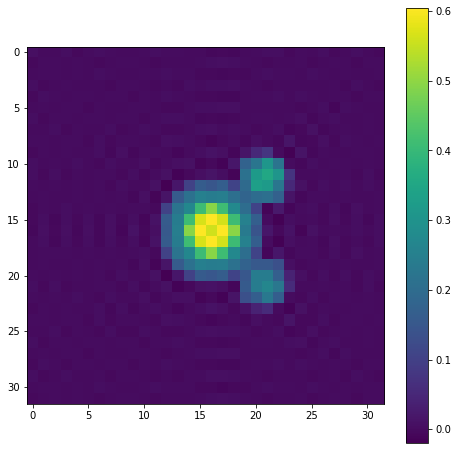

In [12]:
radius = 0.8
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "nn")
s = 17
img = slice_func(0.1*vol_fourier, [0,0,0], [0,0], None)
img_r = jnp.fft.fftshift(jnp.real(jnp.fft.ifft2((img.reshape([nx,nx]))))) 
plt.imshow(img_r); plt.colorbar()

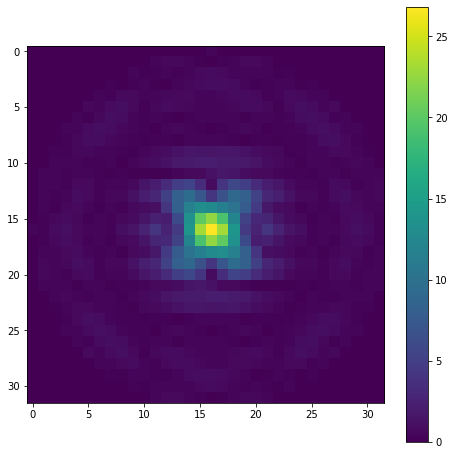

In [14]:
img_f0 = jnp.fft.fftshift(img.reshape([nx,nx]))
plt.imshow(jnp.abs(img_f0));plt.colorbar()

Generate projections (in Fourier domain)

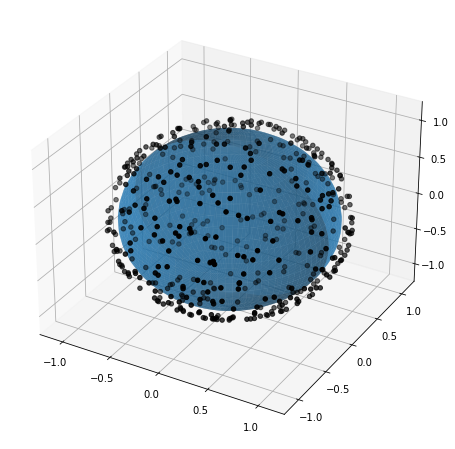

In [15]:
# Orientations
N = 2000

#s = 0.05
s = 0.1
angles_true = generate_uniform_orientations(N)
#jnp.array(np.random.rand(N,3))*jnp.pi*2

#angles_true = jnp.array(np.random.rand(N,3))*jnp.pi/4 + jnp.pi

# Non uniformly distributed orientations (here, two clusters)
#angles_true = s*np.random.randn(int(N),3)
#angles_true = np.concatenate([s*np.random.randn(2250,3), 
#                             s*np.random.randn(2250,3)+np.pi*2/3, 
#                              np.random.rand(500,3)*jnp.pi*2
#                             ], axis=0)
#np.random.shuffle(angles_true)
#angles_true = jnp.array(angles_true)

#angles_true = np.zeros([N,3])
#angles_true[:,1] = s*np.random.randn(N) - np.pi/2
#angles_true = jnp.array(angles_true)

plot_angles(angles_true[:500])

3.877135992050171
0.4267131805544381


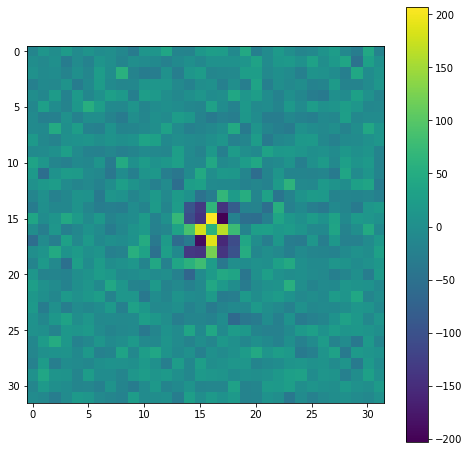

In [16]:
radius = 0.8
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "nn")

img0 = slice_func(vol_fourier, [0,0,0], [0,0], ctf_params0)


shifts_true = jnp.zeros([N,3])
ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true, shifts_true, ctf_params)

norm0 = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

# Noise
imgs += (np.random.randn(N, nx*nx) + 1j*np.random.randn(N, nx*nx)) * jnp.max(img0) *0.1

norm1 = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

print(time.time()-start)

#SNR
print(norm0/norm1)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

### Crop images and volume:

In [17]:
old_nx = jnp.sqrt(imgs.shape[1]).astype(jnp.int64)
nx = 32

if old_nx > 32:
    imgs = imgs.reshape(imgs.shape[0], old_nx, old_nx)
    imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
    imgs = imgs.reshape(imgs.shape[0], nx*nx)
    #imgs2 = imgs2.reshape(imgs2.shape[0], nx*nx)

    vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

    y_grid = x_grid
    z_grid = x_grid

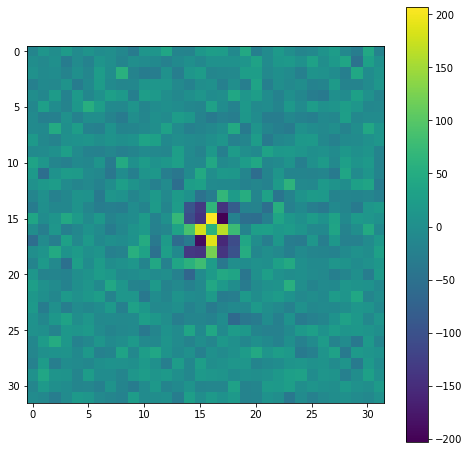

In [18]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

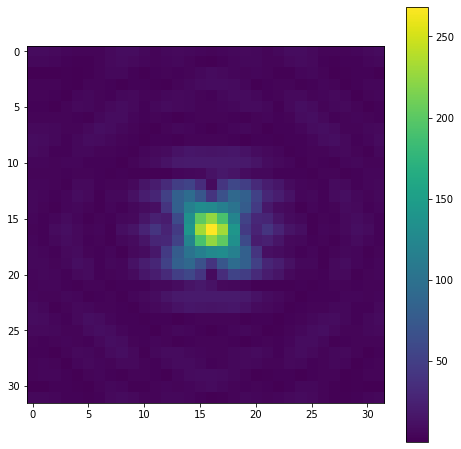

In [19]:
#mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.abs((vol_fourier[:,:,0])))); plt.colorbar()

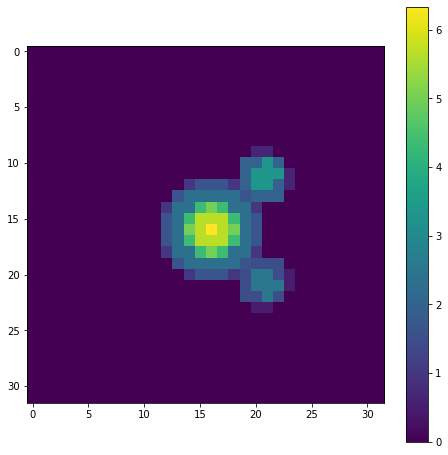

In [20]:
#mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier[:,:,0])))); plt.colorbar()

### Loss functions for the new dimension

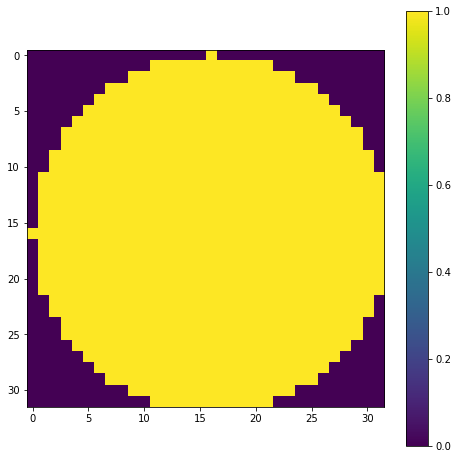

In [21]:
#alpha = 0.01
alpha = 1/N

radius = 0.8 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [24]:
sigma_noise = jnp.ones(nx*nx)

In [26]:
start = time.time()
ll = loss_func_batched(vol_fourier, angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20], sigma_noise)
#ll = loss_func_batched(np.random.randn(nx,nx,nx), angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
print(time.time()-start)
print(ll.shape)

0.008901119232177734
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [29]:
start = time.time()
ll = grad_loss_volume(np.random.randn(nx,nx,nx), angles_true[0],  shifts_true[0], ctf_params[0], imgs[0], sigma_noise)
print(time.time()-start)
print(ll.shape)

0.009156227111816406
(32, 32, 32)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [32]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(np.random.randn(nx,nx,nx), angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx], sigma_noise)
print(time.time()-start)
print(ll.shape)

0.018635034561157227
(32, 32, 32)


### MCMC

In [245]:
#alpha = 0.01
alpha = 0.1/(32*N)

radius = 0.8 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128)
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

logPi = lambda v : -loss_func_sum(v, angles_true, shifts_true, ctf_params, imgs)
gradLogPi = lambda v : -jnp.conj(grad_loss_volume_batched(v, angles_true, shifts_true, ctf_params, imgs))

In [ ]:
#v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = vol_fourier + jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))*50

tau = 0.005
for i in range(100):
    v1, r = mala_proposal(logPi, gradLogPi, v0, tau)
    a = jnp.minimum(1, r)
    
    if np.random.rand() < a:
        print("cool")
        plt.imshow(jnp.abs(v1[:,:,0]-v0[:,:,0])); plt.colorbar(); plt.show()
        #plt.imshow(jnp.abs(jnp.fft.fftshift(v0[:,:,0]))); plt.colorbar(); plt.show()
        v0 = v1
    if jnp.mod(i,10) == 0:
        plt.imshow(jnp.abs(jnp.fft.fftshift(v0[:,:,0]))); plt.colorbar()
        plt.show()
        print(a)
        


### Ab initio

In [36]:
from src.ab_initio import ab_initio

N_samples = 10000
N_iter = 30

dr = 0.05
radius = 0.3
#alpha = 0.001
alpha = 1e-10

use_sgd = True

N_cg_iter = 1000

N_sgd_iter = 310
batch_size = 500
learning_rate = 100
P = None

if use_sgd:
    N_vol_iter = N_sgd_iter
else:
    N_vol_iter = N_cg_iter

eps_vol = 1e-3

out_dir = '../data/'
imgs = imgs.reshape([N, nx*nx])
vcg = ab_initio(project, imgs, sigma_noise, shifts_true, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius, dr, alpha, eps_vol, 'tri', True, True, True, out_dir)

Fourier radius: 0.8
Starting radius: 0.3
Frequency marching step size: 0.05
Number of frequency marching steps: 11
------------------------------------

Initialitsing volume
  sgd epoch 0: mean gradient = 14344.091419489048


KeyboardInterrupt: 

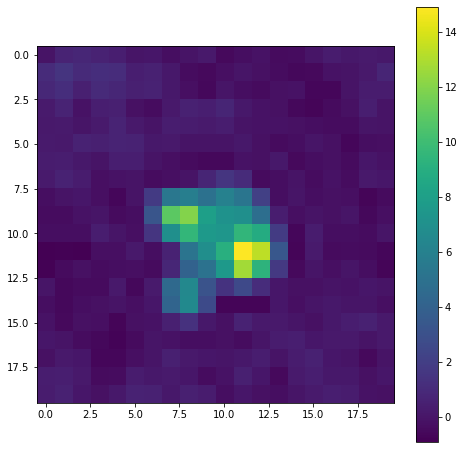

In [23]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg[0,:,:])))); plt.colorbar()

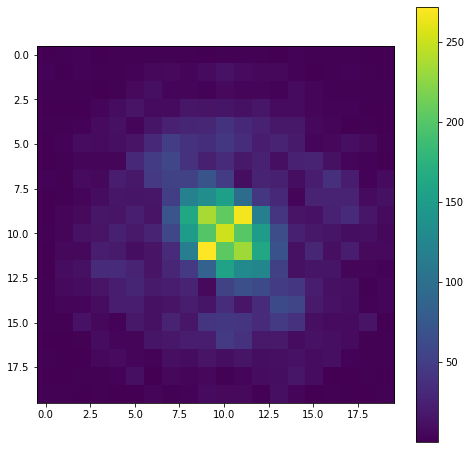

In [24]:
plt.imshow(jnp.abs(jnp.fft.fftshift(vcg[:,:,0]))); plt.colorbar()

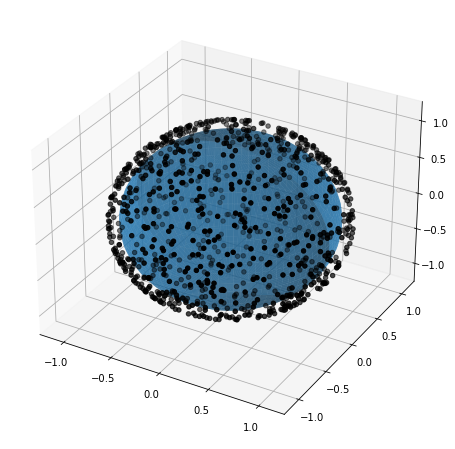

In [20]:
#angles_r = generate_uniform_orientations(400)
plot_angles(angles_true[:1000])

## Optimization with respect to volume

### CG - applied to two halves of the data

In [240]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 300

#N2 = jnp.floor(N/2).astype(jnp.int64)
N2 = 100000
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[:N2], shifts_true[:N2], ctf_params[:N2], imgs[:N2], v0.shape)

vcg1,_ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 0.11899777449961922
  cg iter 50 ||r|| = 3.993613676042548e-05
  cg iter 100 ||r|| = 1.3943973859859222e-05
  cg iter 150 ||r|| = 1.256345521420541e-05
  cg iter 200 ||r|| = 9.232390847334333e-06
  cg iter 250 ||r|| = 8.309980201134342e-06


In [26]:
AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:], v0.shape)

vcg2, _ = conjugate_gradient(AA2, Ab2, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 0.06295050660572052
  cg iter 50 ||r|| = 9.024988878096568e-05
  cg iter 100 ||r|| = 4.648784470884987e-05
  cg iter 150 ||r|| = 4.0087735059284285e-05
  cg iter 200 ||r|| = 3.178357946322257e-05
  cg iter 250 ||r|| = 2.500523467024185e-05
  cg iter 300 ||r|| = 2.513130914932849e-05
  cg iter 350 ||r|| = 2.5238061398510623e-05
  cg iter 400 ||r|| = 2.1782719004277905e-05
  cg iter 450 ||r|| = 2.1868738222962514e-05


In [241]:
#print("Final loss function = ", loss_func_sum(vcg, angles_true, shifts_true, ctf_params, imgs))
print("Relative error = ", jnp.max(jnp.abs((vcg1 - vol_fourier)/jnp.max(vol_fourier))))
print("Absolute error = ", jnp.mean(jnp.abs((vcg1 - vol_fourier))))

Relative error =  0.11342523414054333
Absolute error =  4.353645773585969


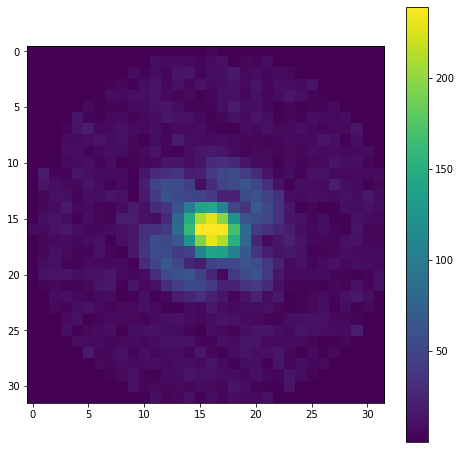

In [242]:
#mip_z(jnp.abs(jnp.fft.fftshift((vcg1)))) ; 
plt.imshow(jnp.abs(jnp.fft.fftshift((vcg1[0,:,:])))) ; 
plt.colorbar()

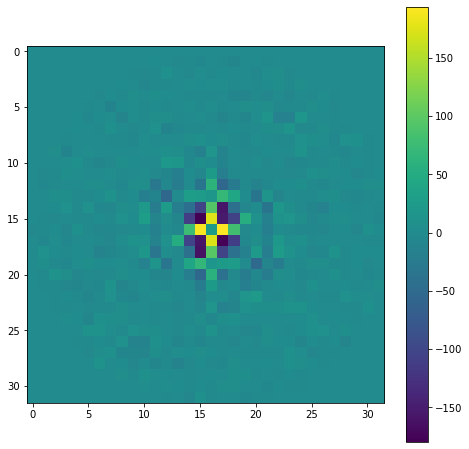

In [243]:
idx = 709

s0 = slice_func(vcg1, angles_true[idx], shifts_true[idx], ctf_params[idx])
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx,nx))); plt.colorbar()

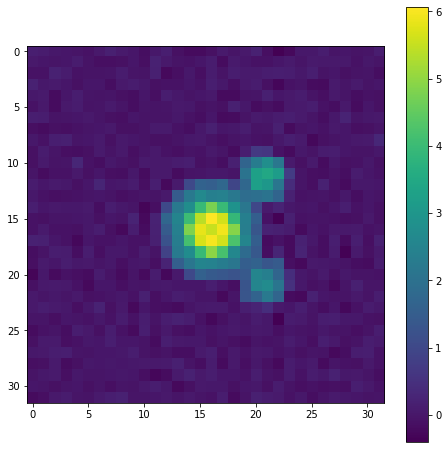

In [245]:
#mip_y(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1[:,:,0]))))
plt.colorbar()
#plt.title('Reconstruction slice')

Text(0.5, 1.0, 'Reconstruction MIP')

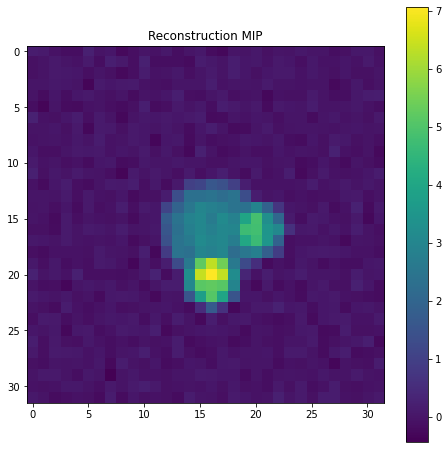

In [250]:
#mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1[0,:,:]))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

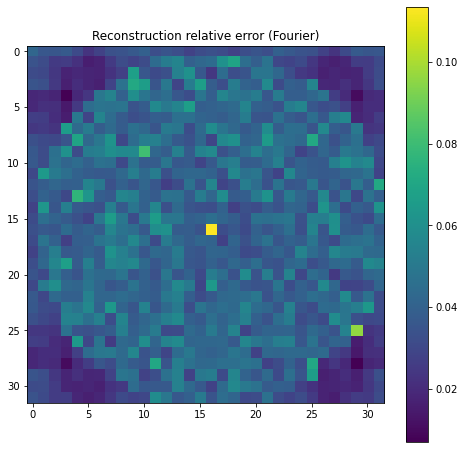

In [251]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

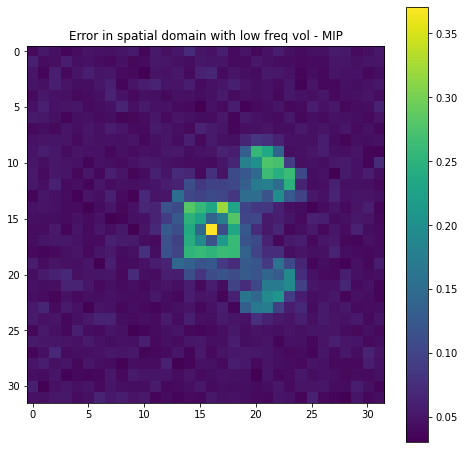

In [252]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier - vcg1)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

In [55]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1)))

with mrcfile.new('../data/simulated_rec_vol.mrc', overwrite=True) as mrc:
    mrc.set_data(vr.astype(np.float32))

### FSC

In [34]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr = 0.05)

In [35]:
points_v_tri = points_orientations_tri(angles_true[:int(N/2)], x_grid[1])
#points_v_nn = points_orientations_nn(angles_true, x_grid[1])


KeyboardInterrupt



In [253]:
points_v_nn = points_orientations_nn(angles_true, x_grid[1])

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow(jnp.fft.fftshift((points_v_tri[0,:,:]*mask[0,:,:]))); plt.colorbar()

In [ ]:
#res_spu, spu_nn = shell_points_used(points_v_nn, x_grid, dr = 0.05)
#plt.plot(res_spu, spu_nn)

### James

The mean is given by CG as applied above, in addition we need to calculate the variances.
The variances are given by the inverse of the gradient (AA) applied to diag(1), i.e. a volume with ones.

Looks good and agrees with counting the points above, but for whatever reason it's mirrored compared to above hmmm.

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

In [ ]:
plt.title("Mean")
plt.imshow((jnp.abs(jnp.fft.fftshift(vcg1[:,:,0])))); plt.colorbar()

#### Train/test stuff - something's wrong here

In [ ]:
res

In [ ]:
loss = []
for radius in res[1:]:
    mask = create_3d_mask(x_grid, (0,0,0),radius)
    mask_imgs = mask[0,:,:].reshape(1,-1)
    ll = loss_func_sum(vcg1 * mask, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:]*mask_imgs)   
    loss.append(ll)
    
loss = jnp.array(loss)

#plt.imshow(jnp.fft.fftshift(mask[:,:,0]))

In [ ]:
plt.plot(res[1:], loss)

### SGD

#### A preconditioner

0.011098890110988899
1.0


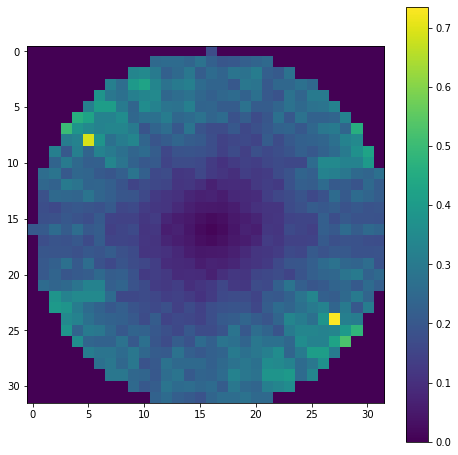

In [254]:
points_v_nn.shape
P = points_v_nn
P += 0.1
P = 1/P  * mask

P = P/jnp.max(P)

plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))

In [43]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
batch_size = N/2
N_epoch = 10
number_of_batches = N/batch_size

alpha = 1000
#alpha = 100000 # <- with normalized precon

sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_batched, angles_true, shifts_true, ctf_params, imgs)
vgd = sgd(sgd_grad_func, N, v0, alpha, N_epoch, batch_size, None, True)

print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((vgd - vol_fourier)/jnp.max(vol_fourier))))

Epoch 0: mean gradient = 4.5832705506244216e-05
Epoch 1: mean gradient = 2.774924528722957e-05
Epoch 2: mean gradient = 1.7033514441030036e-05
Epoch 3: mean gradient = 9.615741221841412e-06
Epoch 4: mean gradient = 5.70854688073025e-06
Epoch 5: mean gradient = 3.382104982361447e-06
Epoch 6: mean gradient = 1.5152152964454374e-06
Epoch 7: mean gradient = 3.266470587331645e-07
Epoch 8: mean gradient = 1.2417757578063283e-06
Epoch 9: mean gradient = 1.6073246565637128e-06
Final loss function (over all data) =  365.7610075835709
Relative error =  0.820429792954194


Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

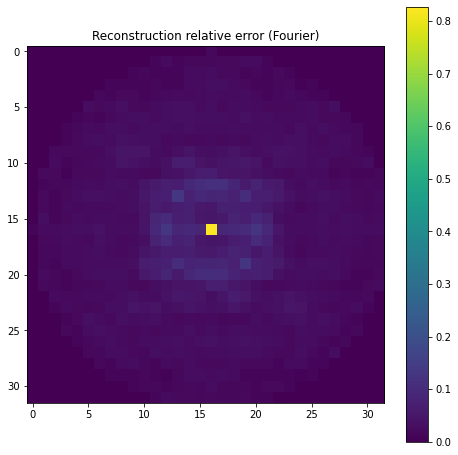

In [34]:
mip_z(jnp.abs(jnp.fft.fftshift((vgd*mask-vol_fourier*mask)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Reconstruction MIP')

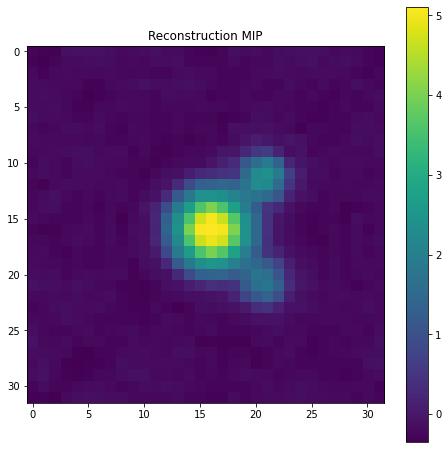

In [35]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgd[:,:,0]*mask[:,:,0]))))
plt.colorbar()
plt.title('Reconstruction MIP')

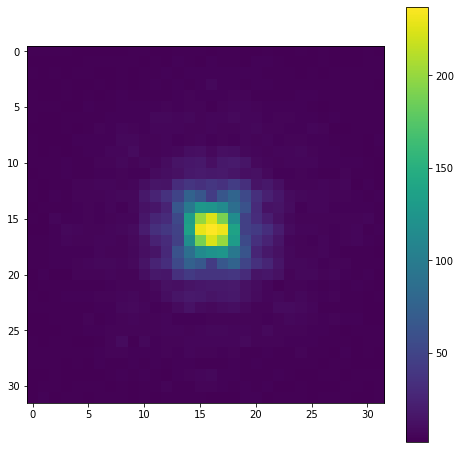

In [40]:
mip_z(jnp.abs(jnp.fft.fftshift((vgd)))) ; plt.colorbar()

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

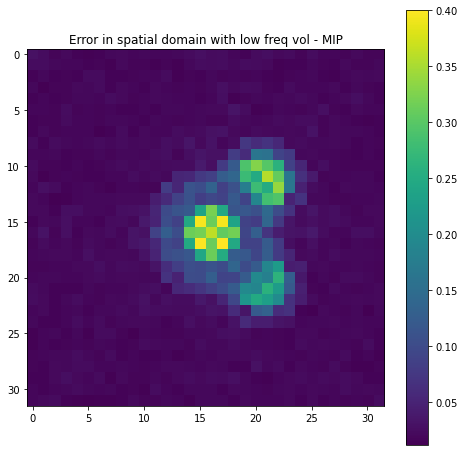

In [36]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - vgd*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

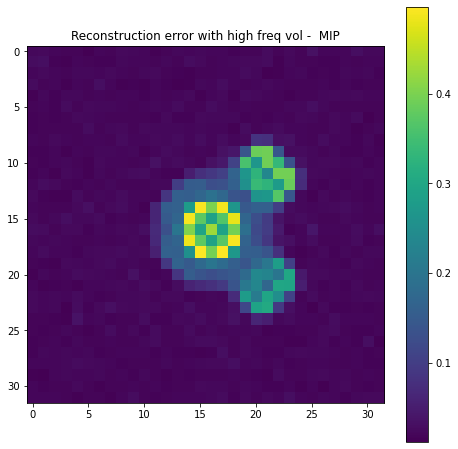

In [37]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vgd)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

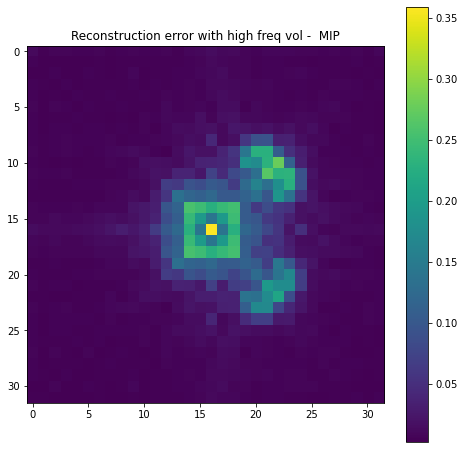

In [38]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vol_fourier*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')